In [2]:
import keras
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from keras.layers import Dense, Conv2D, Input, BatchNormalization, LeakyReLU, Flatten, Reshape
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [3]:
#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [ ]:
##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.

def build_generator():
  noise_shape = (100, ) #1D array of size 100 (latent vector / noise)

  #Define your generator network 
  #Here we are only using Dense layers. But network can be complicated based
  #on the application. For example, you can use VGG for super res. GAN.  

  model = Sequential([
                      Dense(256, input_shape = noise_shape),
                      LeakyReLU(alpha = 0.2),
                      BatchNormalization(momentum = 0.8),
                      Dense(512),
                      LeakyReLU(alpha=0.2),
                      BatchNormalization(momentum = 0.8),
                      Dense(1024),
                      LeakyReLU(alpha=0.2),
                      BatchNormalization(momentum = 0.8),
                      Dense(np.prod(img_shape), activation = 'tanh'),
                      Reshape(img_shape)
  ]) 

  model.summary()

  noise = Input(noise_shape)
  gen_img = model(noise)

  return Model(noise, gen_img)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################


In [ ]:
#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():

  model = Sequential([
                      Flatten(input_shape = img_shape),
                      Dense(512),
                      LeakyReLU(alpha=0.2),
                      Dense(256),
                      LeakyReLU(alpha=0.2),
                      Dense(1, activation='sigmoid')

  ])

  model.summary()

  gen_img = Input(img_shape)
  validity = model(gen_img)

  return Model(gen_img, validity)

#The validity is the Discriminator’s guess of input being real or not

In [ ]:
# Now that we have constructed our two models it’s time to pit them against each other.
# We do this by defining a training function, loading the data set, re-scaling our training
# images and setting the ground truths. 

def train(epochs, batch_size = 128, save_interval = 50):
  # Load the dataset
  (X_train, _), (_, _) = mnist.load_data()

  # convert to float
  X_train = X_train.astype('float32')/127.5 - 1

  # adding 3rd dimenison
  X_train = np.expand_dims(X_train, axis = 3)

  half_batch = batch_size//2

# We then loop through a number of epochs to train our Discriminator by first selecting
# a random batch of images from our true dataset, generating a set of images from our
# Generator, feeding both set of images into our Discriminator, and finally setting the
# loss parameters for both the real and fake images, as well as the combined loss. 

  for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of real images

    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, 100))

    # Generate a half batch of fake images
    gen_imgs = generator.predict(noise)

    # Train the discriminator on real and fake images, separately
    # Research showed that separate training is more effective.

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

    #take average loss from real and fake images. 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # And within the same loop we train our Generator, by setting the input noise and
    # ultimately training the Generator to have the Discriminator label its samples as valid
    # by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
    # Create noise vectors as input for generator. 
    # Create as many noise vectors as defined by the batch size. 
    # Based on normal distribution. Output will be of size (batch size, 100)

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    # This is where the genrator is trying to trick discriminator into believing
    # the generated image is true (hence value of 1 for y)

    valid_y = np.array([1]*batch_size)

    # Generator is part of combined where it got directly linked with the discriminator
    # Train the generator with noise as x and 1 as y. 
    # Again, 1 as the output as it is adversarial and if generator did a great
    # job of folling the discriminator then the output would be 1 (true)

    g_loss = combined.train_on_batch(noise, valid_y)

    # Additionally, in order for us to keep track of our training process, we print the
    # progress and save the sample image output depending on the epoch interval specified.  
    # Plot the progress 

    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
      save_imgs(epoch)



In [ ]:
#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def save_imgs(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5 

  fig, axs = plt.subplots(r, c)
  cnt = 0 

  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1

  fig.savefig('/content/drive/MyDrive/GAN_MNIST/generated_images/gen_img_%d.png' % epoch)
  plt.close()

  #This function saves our images for us to view


In [ ]:
# Let us also define our optimizer for easy use later on.
# That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
# Generator will be trained as part of the combined model, later. 
# pick the loss function and the type of metric to keep track.                 
# Binary cross entropy as we are doing prediction and it is a better
# loss function compared to MSE or other.

discriminator = build_discriminator()
discriminator.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Since we are only generating (faking) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

## This builds the Generator and defines the input noise. 
# In a GAN the Generator network takes noise z as an input to produce its images. 

noise = Input(shape = (100,))
img = generator(noise)

# This ensures that when we combine our networks we only train the Generator.
# While generator training we do not want discriminator weights to be adjusted. 
# This Doesn't affect the above descriminator training.  
discriminator.trainable = False

# This specifies that our Discriminator will take the images generated by our Generator
# and true dataset and set its output to a parameter called valid, which will indicate
# whether the input is real or not. 

valid = discriminator(img)

# Here we combined the models and also set our loss function and optimizer. 
# Again, we are only training the generator here. 
# The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(noise, valid)
combined.compile(loss = 'binary_crossentropy', optimizer = optimizer)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
__________________________________________________

In [ ]:
train(epochs = 20000, batch_size = 2048, save_interval = 250)

In [ ]:
generator.save('/content/drive/MyDrive/GAN_MNIST/model/generate_mnist.h5')

In [ ]:
gen_model = keras.models.load_model('/content/drive/MyDrive/GAN_MNIST/model/generate_mnist.h5')

In [ ]:
def predict(vec):
  vec = np.expand_dims(vec, axis = 0)
  img = generator.predict(vec)[0, :, :, 0]
  # rescale img
  img = (img + 1)*127.5
  return img


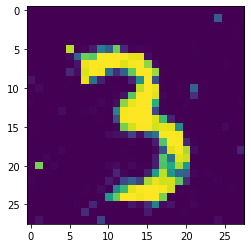

In [ ]:
noise_vec = np.random.normal(0, 1, (100,))
show_img(noise_vec)

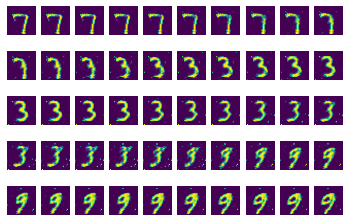

In [ ]:
vecs = np.linspace(-5, 10, 50)
vecs = vecs.reshape(5, 10)
noise_vec_copy = noise_vec.copy()
fig, axs = plt.subplots(5, 10)
for i in range(5):
  for j in range(10):
    noise_vec_copy[3] = vecs[i, j]
    axs[i, j].imshow(predict(noise_vec_copy))
    axs[i, j].axis('off')

### Using Convolutional Layers to build generator and discriminator

In [16]:
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Input, Reshape, Conv2DTranspose

def build_generator_conv():
  # we are given an input noise of shape (100, )
  # so first we reshape it to (10, 10)

  noise_shape = (25, )
  
  inputs = Input(noise_shape)
  x = Reshape((5, 5, 1))(inputs)

  # Transpose Conv2d layer 1
  x = Conv2DTranspose(filters = 256, kernel_size = (4, 4), strides= (1, 1), padding = 'valid')(x)
  x = BatchNormalization(momentum = 0.5)(x)
  x = LeakyReLU(0.2)(x)

  # Transpose Conv2d layer 2
  x = Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides= (2, 2), padding = 'same')(x)
  x = BatchNormalization(momentum = 0.5)(x)
  x = LeakyReLU(0.2)(x)

  # Transpose Conv2d layer 3
  x = Conv2DTranspose(filters = 64, kernel_size = (4, 4), strides= (2, 2), padding = 'same')(x)
  x = BatchNormalization(momentum = 0.5)(x)
  x = LeakyReLU(0.2)(x)

  #  Conv layer 4
  x = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid')(x)
  x = BatchNormalization(momentum = 0.5)(x)
  x = LeakyReLU(0.2)(x)

  # Conv layer 5
  x = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid')(x)
  x = BatchNormalization(momentum = 0.5)(x)
  x = LeakyReLU(0.2)(x)

  # Transpose Conv2d layer 2
  x = Conv2D(filters = 1, kernel_size = (3, 3), padding = 'same', activation = 'sigmoid')(x)

  model = Model(inputs, x)
  opt = Adam(lr=0.00015, beta_1=0.5)

  model.compile(metrics = ['accuracy'], loss = 'binary_crossentropy', optimizer = opt)
  model.summary()

  ## Input shape (m, 25)
  ## Output shape (m, 28, 28, 1)

  return model

In [34]:
def build_discriminator_conv():
  model = Sequential([
      Input((28, 28, 1)),
      Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'),
      Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'),
      Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', strides = (1, 1), activation = 'relu'),
      Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', strides = (1, 1), activation = 'relu'),
      Flatten(),
      Dense(32, activation = 'relu'),
      Dense(1, activation = 'sigmoid')
  ])

  opt = Adam(lr=0.00015, beta_1=0.5)

  model.compile(metrics = ['accuracy'], loss = 'binary_crossentropy', optimizer = opt)
  model.summary()

  return model

In [33]:
build_discriminator_conv()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 conv2d_17 (Conv2D)          (None, 7, 7, 64)          73792     
                                                                 
 conv2d_18 (Conv2D)          (None, 5, 5, 32)          18464     
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 16)          4624      
                                                                 
 flatten_2 (Flatten)         (None, 144)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                4640      
                                                                 
 dense_5 (Dense)             (None, 1)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
#when the specific sample_interval is hit, we call the
#sample_image function. Which looks as follows.

def show_imgs():
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 25))
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(r, c)
  cnt = 0 

  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
      axs[i, j].axis('off')
      cnt += 1

  plt.show()

  #This function saves our images for us to view


In [55]:
def train_conv(epochs = 10000, batch_size = 128, print_interval = 100):
  (X_train, _), (_, _) = mnist.load_data()

  X_train = X_train/255

  X_train = np.expand_dims(X_train, axis = 3)

  print(X_train.shape)

  half_batch = batch_size//2

  for epoch in range(epochs):
      # Training the disrciminator
      discriminator.trainable = True

      # Selecting random half batch of images
      idx = np.random.randint(0, X_train[0].shape[0], half_batch)
      imgs = X_train[idx]

      noise = np.random.normal(0, 1, (half_batch, 25))

      # generate half batch of fake images
      gen_imgs = generator.predict(noise)

      d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
      d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      ## turning of discriminator
      discriminator.trainable = False

      ## Train generator

      noise = np.random.normal(0, 1, (batch_size, 25))
      valid_y = np.array([1]*batch_size)

      g_loss = combined.train_on_batch(noise, valid_y)

      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

      if epoch % print_interval == 0:
        show_imgs()

In [53]:
generator = build_generator_conv()
discriminator = build_discriminator_conv()

combined = Sequential([
    generator, discriminator
])

opt = Adam(lr=0.00015, beta_1=0.5)

combined.compile(loss = 'binary_crossentropy', optimizer = opt)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 25)]              0         
                                                                 
 reshape_10 (Reshape)        (None, 5, 5, 1)           0         
                                                                 
 conv2d_transpose_38 (Conv2D  (None, 8, 8, 256)        4352      
 Transpose)                                                      
                                                                 
 batch_normalization_45 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_39 (Conv2D  (None, 16, 16, 128)      524

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 conv2d_45 (Conv2D)          (None, 7, 7, 64)          73792     
                                                                 
 conv2d_46 (Conv2D)          (None, 5, 5, 32)          18464     
                                                                 
 conv2d_47 (Conv2D)          (None, 3, 3, 16)          4624      
                                                                 
 flatten_6 (Flatten)         (None, 144)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4640      
                                                                 
 dense_13 (Dense)            (None, 1)                

(60000, 28, 28, 1)
0 [D loss: 0.692055, acc.: 67.97%] [G loss: 0.696243]


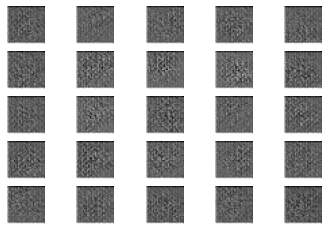

1 [D loss: 0.690129, acc.: 86.28%] [G loss: 0.689782]
2 [D loss: 0.689210, acc.: 97.71%] [G loss: 0.682832]
3 [D loss: 0.689244, acc.: 51.90%] [G loss: 0.675758]
4 [D loss: 0.691224, acc.: 50.05%] [G loss: 0.670891]
5 [D loss: 0.694475, acc.: 50.00%] [G loss: 0.667853]
6 [D loss: 0.696822, acc.: 50.00%] [G loss: 0.664727]
7 [D loss: 0.697224, acc.: 50.00%] [G loss: 0.662318]
8 [D loss: 0.696828, acc.: 50.00%] [G loss: 0.659994]
9 [D loss: 0.694934, acc.: 50.00%] [G loss: 0.658170]
10 [D loss: 0.692081, acc.: 50.00%] [G loss: 0.656373]
11 [D loss: 0.689536, acc.: 50.00%] [G loss: 0.652894]
12 [D loss: 0.686206, acc.: 50.00%] [G loss: 0.648192]
13 [D loss: 0.683066, acc.: 50.00%] [G loss: 0.641355]
14 [D loss: 0.678844, acc.: 50.00%] [G loss: 0.633357]
15 [D loss: 0.677089, acc.: 50.00%] [G loss: 0.624083]
16 [D loss: 0.673639, acc.: 50.00%] [G loss: 0.612041]
17 [D loss: 0.669336, acc.: 50.00%] [G loss: 0.600509]
18 [D loss: 0.668126, acc.: 50.00%] [G loss: 0.582880]
19 [D loss: 0.67725

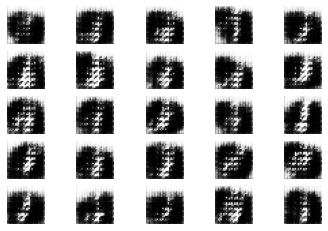

101 [D loss: 0.675458, acc.: 50.00%] [G loss: 0.395408]
102 [D loss: 0.797443, acc.: 50.00%] [G loss: 0.403905]
103 [D loss: 0.644042, acc.: 50.00%] [G loss: 0.404204]
104 [D loss: 0.723455, acc.: 50.00%] [G loss: 0.398172]
105 [D loss: 0.746463, acc.: 50.00%] [G loss: 0.403911]
106 [D loss: 0.679396, acc.: 50.00%] [G loss: 0.404438]
107 [D loss: 0.723406, acc.: 50.00%] [G loss: 0.407590]
108 [D loss: 0.698307, acc.: 50.05%] [G loss: 0.407421]
109 [D loss: 0.691706, acc.: 50.10%] [G loss: 0.404649]
110 [D loss: 0.728532, acc.: 50.00%] [G loss: 0.404396]
111 [D loss: 0.700766, acc.: 50.00%] [G loss: 0.406276]
112 [D loss: 0.719967, acc.: 50.00%] [G loss: 0.405988]
113 [D loss: 0.673223, acc.: 50.00%] [G loss: 0.403888]
114 [D loss: 0.728086, acc.: 50.00%] [G loss: 0.401955]
115 [D loss: 0.664427, acc.: 50.00%] [G loss: 0.398755]
116 [D loss: 0.757470, acc.: 50.00%] [G loss: 0.403313]
117 [D loss: 0.640558, acc.: 50.00%] [G loss: 0.399033]
118 [D loss: 0.813182, acc.: 50.00%] [G loss: 0.

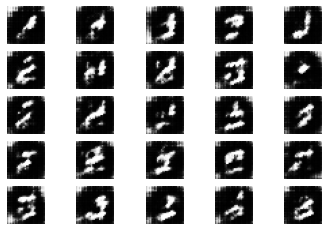

201 [D loss: 0.717735, acc.: 50.00%] [G loss: 0.376841]
202 [D loss: 0.820356, acc.: 50.00%] [G loss: 0.381852]
203 [D loss: 0.780694, acc.: 50.00%] [G loss: 0.382049]
204 [D loss: 0.745424, acc.: 50.00%] [G loss: 0.381155]
205 [D loss: 0.832396, acc.: 50.00%] [G loss: 0.381049]
206 [D loss: 0.674294, acc.: 50.00%] [G loss: 0.380499]
207 [D loss: 0.936735, acc.: 50.00%] [G loss: 0.386288]
208 [D loss: 0.512571, acc.: 52.20%] [G loss: 0.382770]
209 [D loss: 1.032361, acc.: 50.00%] [G loss: 0.372761]
210 [D loss: 0.603658, acc.: 50.05%] [G loss: 0.360182]
211 [D loss: 0.837887, acc.: 50.00%] [G loss: 0.361892]
212 [D loss: 0.902211, acc.: 50.00%] [G loss: 0.374500]
213 [D loss: 0.652552, acc.: 50.00%] [G loss: 0.376140]
214 [D loss: 0.888070, acc.: 50.00%] [G loss: 0.369390]
215 [D loss: 0.746090, acc.: 50.00%] [G loss: 0.374455]
216 [D loss: 0.834699, acc.: 50.00%] [G loss: 0.377337]
217 [D loss: 0.756453, acc.: 50.00%] [G loss: 0.381736]
218 [D loss: 0.829996, acc.: 50.00%] [G loss: 0.

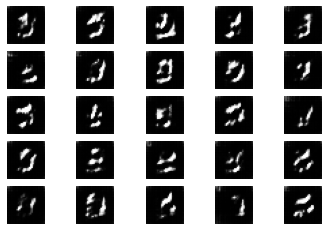

301 [D loss: 0.844633, acc.: 50.00%] [G loss: 0.345684]
302 [D loss: 0.822603, acc.: 50.00%] [G loss: 0.346018]
303 [D loss: 0.831804, acc.: 50.00%] [G loss: 0.345064]
304 [D loss: 0.829277, acc.: 50.00%] [G loss: 0.344903]
305 [D loss: 0.821553, acc.: 50.00%] [G loss: 0.344226]
306 [D loss: 0.830717, acc.: 50.00%] [G loss: 0.343819]
307 [D loss: 0.818968, acc.: 50.00%] [G loss: 0.342629]
308 [D loss: 0.830840, acc.: 50.00%] [G loss: 0.343652]
309 [D loss: 0.826702, acc.: 50.00%] [G loss: 0.343483]
310 [D loss: 0.826721, acc.: 50.00%] [G loss: 0.344210]
311 [D loss: 0.835891, acc.: 50.00%] [G loss: 0.344405]
312 [D loss: 0.807428, acc.: 50.00%] [G loss: 0.344413]
313 [D loss: 0.840729, acc.: 50.00%] [G loss: 0.343152]
314 [D loss: 0.807755, acc.: 50.00%] [G loss: 0.345495]
315 [D loss: 0.843515, acc.: 50.00%] [G loss: 0.343237]
316 [D loss: 0.811892, acc.: 50.00%] [G loss: 0.345170]
317 [D loss: 0.844893, acc.: 50.00%] [G loss: 0.342678]
318 [D loss: 0.812614, acc.: 50.00%] [G loss: 0.

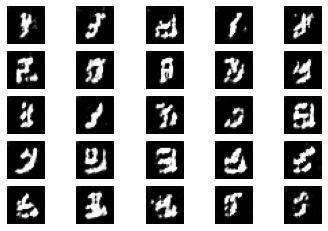

401 [D loss: 0.818978, acc.: 50.00%] [G loss: 0.345550]
402 [D loss: 0.837583, acc.: 50.00%] [G loss: 0.340555]
403 [D loss: 0.835326, acc.: 50.00%] [G loss: 0.341900]
404 [D loss: 0.838481, acc.: 50.00%] [G loss: 0.339540]
405 [D loss: 0.840264, acc.: 50.00%] [G loss: 0.338906]
406 [D loss: 0.835511, acc.: 50.00%] [G loss: 0.341688]
407 [D loss: 0.837472, acc.: 50.00%] [G loss: 0.341991]
408 [D loss: 0.831768, acc.: 50.00%] [G loss: 0.341090]
409 [D loss: 0.842392, acc.: 50.00%] [G loss: 0.338048]
410 [D loss: 0.839769, acc.: 50.00%] [G loss: 0.334090]
411 [D loss: 0.829419, acc.: 50.00%] [G loss: 0.342287]
412 [D loss: 0.840854, acc.: 50.00%] [G loss: 0.337576]
413 [D loss: 0.821042, acc.: 50.00%] [G loss: 0.346555]
414 [D loss: 0.836253, acc.: 50.00%] [G loss: 0.337579]
415 [D loss: 0.843898, acc.: 50.00%] [G loss: 0.335302]
416 [D loss: 0.839378, acc.: 50.00%] [G loss: 0.336805]
417 [D loss: 0.844115, acc.: 50.00%] [G loss: 0.336621]
418 [D loss: 0.839648, acc.: 50.00%] [G loss: 0.

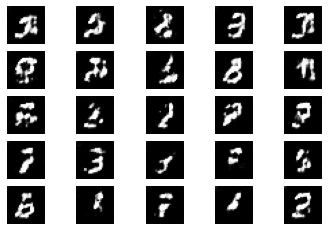

501 [D loss: 0.855088, acc.: 50.00%] [G loss: 0.331413]
502 [D loss: 0.850874, acc.: 50.00%] [G loss: 0.328546]
503 [D loss: 0.857169, acc.: 50.00%] [G loss: 0.327348]
504 [D loss: 0.855864, acc.: 50.00%] [G loss: 0.331690]
505 [D loss: 0.846074, acc.: 50.00%] [G loss: 0.327035]
506 [D loss: 0.857671, acc.: 50.00%] [G loss: 0.334652]
507 [D loss: 0.837875, acc.: 50.00%] [G loss: 0.327993]
508 [D loss: 0.849780, acc.: 50.00%] [G loss: 0.339295]
509 [D loss: 0.841687, acc.: 50.00%] [G loss: 0.329825]
510 [D loss: 0.861706, acc.: 50.00%] [G loss: 0.327467]
511 [D loss: 0.858154, acc.: 50.00%] [G loss: 0.330731]
512 [D loss: 0.849492, acc.: 50.00%] [G loss: 0.329837]
513 [D loss: 0.853103, acc.: 50.00%] [G loss: 0.327974]
514 [D loss: 0.856883, acc.: 50.00%] [G loss: 0.333292]
515 [D loss: 0.847604, acc.: 50.00%] [G loss: 0.332051]
516 [D loss: 0.855728, acc.: 50.00%] [G loss: 0.333708]
517 [D loss: 0.852237, acc.: 50.00%] [G loss: 0.330536]
518 [D loss: 0.860932, acc.: 50.00%] [G loss: 0.

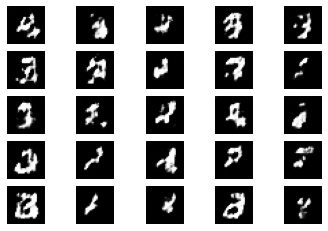

601 [D loss: 0.853006, acc.: 50.00%] [G loss: 0.334671]
602 [D loss: 0.851680, acc.: 50.00%] [G loss: 0.329477]
603 [D loss: 0.866091, acc.: 50.00%] [G loss: 0.328222]
604 [D loss: 0.862700, acc.: 50.00%] [G loss: 0.334732]
605 [D loss: 0.852299, acc.: 50.00%] [G loss: 0.332306]
606 [D loss: 0.857331, acc.: 50.00%] [G loss: 0.330982]
607 [D loss: 0.856670, acc.: 50.00%] [G loss: 0.332482]
608 [D loss: 0.858603, acc.: 50.00%] [G loss: 0.332639]
609 [D loss: 0.850918, acc.: 50.00%] [G loss: 0.330643]
610 [D loss: 0.867700, acc.: 50.00%] [G loss: 0.336535]
611 [D loss: 0.853065, acc.: 50.00%] [G loss: 0.336399]
612 [D loss: 0.843251, acc.: 50.00%] [G loss: 0.326485]
613 [D loss: 0.868707, acc.: 50.00%] [G loss: 0.339923]
614 [D loss: 0.843638, acc.: 50.00%] [G loss: 0.339459]
615 [D loss: 0.844541, acc.: 50.00%] [G loss: 0.324660]
616 [D loss: 0.874045, acc.: 50.00%] [G loss: 0.332319]
617 [D loss: 0.857869, acc.: 50.00%] [G loss: 0.333477]
618 [D loss: 0.834267, acc.: 50.00%] [G loss: 0.

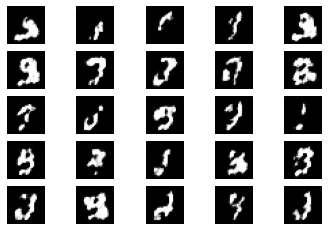

701 [D loss: 0.878128, acc.: 50.00%] [G loss: 0.318804]
702 [D loss: 0.879202, acc.: 50.00%] [G loss: 0.320309]
703 [D loss: 0.877932, acc.: 50.00%] [G loss: 0.320336]
704 [D loss: 0.880226, acc.: 50.00%] [G loss: 0.323626]
705 [D loss: 0.870741, acc.: 50.00%] [G loss: 0.322695]
706 [D loss: 0.878522, acc.: 50.00%] [G loss: 0.322624]
707 [D loss: 0.878436, acc.: 50.00%] [G loss: 0.322753]
708 [D loss: 0.874547, acc.: 50.00%] [G loss: 0.321402]
709 [D loss: 0.875061, acc.: 50.00%] [G loss: 0.319347]
710 [D loss: 0.885310, acc.: 50.00%] [G loss: 0.322261]
711 [D loss: 0.871854, acc.: 50.00%] [G loss: 0.322523]
712 [D loss: 0.875776, acc.: 50.00%] [G loss: 0.321727]
713 [D loss: 0.874598, acc.: 50.00%] [G loss: 0.317587]
714 [D loss: 0.891269, acc.: 50.00%] [G loss: 0.322474]
715 [D loss: 0.870985, acc.: 50.00%] [G loss: 0.324085]
716 [D loss: 0.870826, acc.: 50.00%] [G loss: 0.320325]
717 [D loss: 0.881067, acc.: 50.00%] [G loss: 0.318082]
718 [D loss: 0.884272, acc.: 50.00%] [G loss: 0.

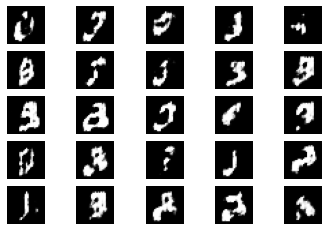

801 [D loss: 0.876375, acc.: 50.00%] [G loss: 0.320955]
802 [D loss: 0.879538, acc.: 50.00%] [G loss: 0.319796]
803 [D loss: 0.887371, acc.: 50.00%] [G loss: 0.322405]
804 [D loss: 0.879046, acc.: 50.00%] [G loss: 0.320708]
805 [D loss: 0.877000, acc.: 50.00%] [G loss: 0.315997]
806 [D loss: 0.892152, acc.: 50.00%] [G loss: 0.319993]
807 [D loss: 0.876526, acc.: 50.00%] [G loss: 0.322902]
808 [D loss: 0.878423, acc.: 50.00%] [G loss: 0.320775]
809 [D loss: 0.876133, acc.: 50.00%] [G loss: 0.317690]
810 [D loss: 0.891506, acc.: 50.00%] [G loss: 0.325081]
811 [D loss: 0.868806, acc.: 50.00%] [G loss: 0.323576]
812 [D loss: 0.875534, acc.: 50.00%] [G loss: 0.318915]
813 [D loss: 0.884824, acc.: 50.00%] [G loss: 0.316835]
814 [D loss: 0.888101, acc.: 50.00%] [G loss: 0.318426]
815 [D loss: 0.878130, acc.: 50.00%] [G loss: 0.319381]
816 [D loss: 0.877255, acc.: 50.00%] [G loss: 0.316835]
817 [D loss: 0.891332, acc.: 50.00%] [G loss: 0.321349]
818 [D loss: 0.875715, acc.: 50.00%] [G loss: 0.

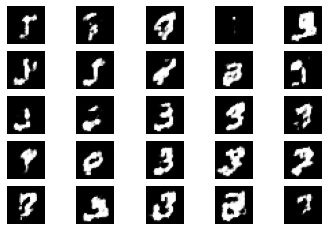

901 [D loss: 0.869508, acc.: 50.00%] [G loss: 0.319529]
902 [D loss: 0.870840, acc.: 50.00%] [G loss: 0.319058]
903 [D loss: 0.871126, acc.: 50.00%] [G loss: 0.319627]
904 [D loss: 0.867921, acc.: 50.00%] [G loss: 0.318101]
905 [D loss: 0.875086, acc.: 50.00%] [G loss: 0.318886]
906 [D loss: 0.869535, acc.: 50.00%] [G loss: 0.320257]
907 [D loss: 0.870445, acc.: 50.00%] [G loss: 0.323642]
908 [D loss: 0.861834, acc.: 50.00%] [G loss: 0.321053]
909 [D loss: 0.872442, acc.: 50.00%] [G loss: 0.323943]
910 [D loss: 0.868201, acc.: 50.00%] [G loss: 0.324082]
911 [D loss: 0.867115, acc.: 50.00%] [G loss: 0.319956]
912 [D loss: 0.871413, acc.: 50.00%] [G loss: 0.318047]
913 [D loss: 0.876774, acc.: 50.00%] [G loss: 0.317698]
914 [D loss: 0.877908, acc.: 50.00%] [G loss: 0.321687]
915 [D loss: 0.871532, acc.: 50.00%] [G loss: 0.324825]
916 [D loss: 0.861793, acc.: 50.00%] [G loss: 0.323239]
917 [D loss: 0.874088, acc.: 50.00%] [G loss: 0.326173]
918 [D loss: 0.867356, acc.: 50.00%] [G loss: 0.

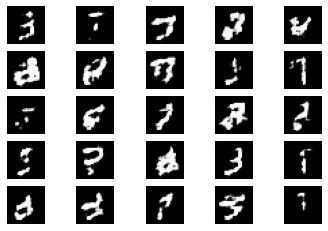

1001 [D loss: 0.876439, acc.: 50.00%] [G loss: 0.329022]
1002 [D loss: 0.886936, acc.: 50.00%] [G loss: 0.334735]
1003 [D loss: 0.869318, acc.: 50.00%] [G loss: 0.335434]
1004 [D loss: 0.874173, acc.: 50.00%] [G loss: 0.337084]
1005 [D loss: 0.866754, acc.: 50.00%] [G loss: 0.333528]
1006 [D loss: 0.882335, acc.: 50.00%] [G loss: 0.340717]
1007 [D loss: 0.868410, acc.: 50.00%] [G loss: 0.335768]
1008 [D loss: 0.871058, acc.: 50.00%] [G loss: 0.327978]
1009 [D loss: 0.886892, acc.: 50.00%] [G loss: 0.327085]
1010 [D loss: 0.884504, acc.: 50.00%] [G loss: 0.331920]
1011 [D loss: 0.875167, acc.: 50.00%] [G loss: 0.332867]
1012 [D loss: 0.875595, acc.: 50.00%] [G loss: 0.332203]
1013 [D loss: 0.874990, acc.: 50.00%] [G loss: 0.328978]
1014 [D loss: 0.888057, acc.: 50.00%] [G loss: 0.335260]
1015 [D loss: 0.870450, acc.: 50.00%] [G loss: 0.335401]
1016 [D loss: 0.876997, acc.: 50.00%] [G loss: 0.332663]
1017 [D loss: 0.877186, acc.: 50.00%] [G loss: 0.329990]
1018 [D loss: 0.885428, acc.: 5

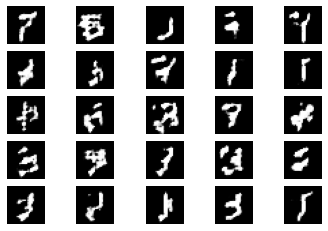

1101 [D loss: 0.908015, acc.: 50.00%] [G loss: 0.302355]
1102 [D loss: 0.927480, acc.: 50.00%] [G loss: 0.300827]
1103 [D loss: 0.928887, acc.: 50.00%] [G loss: 0.304045]
1104 [D loss: 0.915358, acc.: 50.00%] [G loss: 0.303458]
1105 [D loss: 0.925458, acc.: 50.00%] [G loss: 0.305024]
1106 [D loss: 0.917902, acc.: 50.00%] [G loss: 0.304969]
1107 [D loss: 0.917938, acc.: 50.00%] [G loss: 0.304917]
1108 [D loss: 0.921496, acc.: 50.00%] [G loss: 0.304784]
1109 [D loss: 0.920669, acc.: 50.00%] [G loss: 0.306526]
1110 [D loss: 0.910829, acc.: 50.00%] [G loss: 0.304003]
1111 [D loss: 0.917946, acc.: 50.00%] [G loss: 0.302657]
1112 [D loss: 0.923683, acc.: 50.00%] [G loss: 0.304120]
1113 [D loss: 0.923635, acc.: 50.00%] [G loss: 0.308273]
1114 [D loss: 0.907792, acc.: 50.00%] [G loss: 0.306854]
1115 [D loss: 0.918029, acc.: 50.00%] [G loss: 0.304937]
1116 [D loss: 0.910309, acc.: 50.00%] [G loss: 0.301162]
1117 [D loss: 0.933543, acc.: 50.00%] [G loss: 0.305040]
1118 [D loss: 0.918376, acc.: 5

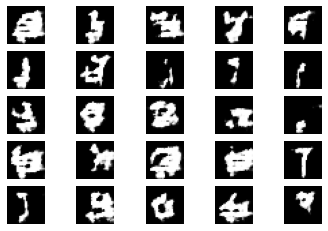

1201 [D loss: 0.917835, acc.: 50.00%] [G loss: 0.310185]
1202 [D loss: 0.901917, acc.: 50.00%] [G loss: 0.311909]
1203 [D loss: 0.899499, acc.: 50.00%] [G loss: 0.308233]
1204 [D loss: 0.906109, acc.: 50.00%] [G loss: 0.305122]
1205 [D loss: 0.912006, acc.: 50.00%] [G loss: 0.304586]
1206 [D loss: 0.914528, acc.: 50.00%] [G loss: 0.306689]
1207 [D loss: 0.908087, acc.: 50.00%] [G loss: 0.307941]
1208 [D loss: 0.902127, acc.: 50.00%] [G loss: 0.305245]
1209 [D loss: 0.914573, acc.: 50.00%] [G loss: 0.307622]
1210 [D loss: 0.904731, acc.: 50.00%] [G loss: 0.308416]
1211 [D loss: 0.908368, acc.: 50.00%] [G loss: 0.310598]
1212 [D loss: 0.903680, acc.: 50.00%] [G loss: 0.311691]
1213 [D loss: 0.907206, acc.: 50.00%] [G loss: 0.313605]
1214 [D loss: 0.896001, acc.: 50.00%] [G loss: 0.307209]
1215 [D loss: 0.917945, acc.: 50.00%] [G loss: 0.307991]
1216 [D loss: 0.908980, acc.: 50.00%] [G loss: 0.310381]
1217 [D loss: 0.895833, acc.: 50.00%] [G loss: 0.305558]
1218 [D loss: 0.916753, acc.: 5

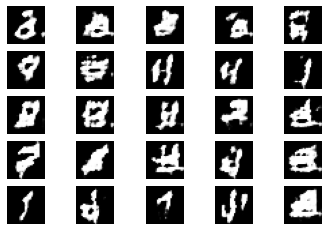

1301 [D loss: 0.915514, acc.: 50.00%] [G loss: 0.303721]
1302 [D loss: 0.905987, acc.: 50.00%] [G loss: 0.303425]
1303 [D loss: 0.900136, acc.: 50.00%] [G loss: 0.300518]
1304 [D loss: 0.910476, acc.: 50.00%] [G loss: 0.300795]
1305 [D loss: 0.908038, acc.: 50.00%] [G loss: 0.299914]
1306 [D loss: 0.904798, acc.: 50.00%] [G loss: 0.297880]
1307 [D loss: 0.912566, acc.: 50.00%] [G loss: 0.301677]
1308 [D loss: 0.908005, acc.: 50.00%] [G loss: 0.303370]
1309 [D loss: 0.895875, acc.: 50.00%] [G loss: 0.300847]
1310 [D loss: 0.907056, acc.: 50.00%] [G loss: 0.303032]
1311 [D loss: 0.910160, acc.: 50.00%] [G loss: 0.302987]
1312 [D loss: 0.904129, acc.: 50.00%] [G loss: 0.300267]
1313 [D loss: 0.898234, acc.: 50.00%] [G loss: 0.296610]
1314 [D loss: 0.916138, acc.: 50.00%] [G loss: 0.295397]
1315 [D loss: 0.914256, acc.: 50.00%] [G loss: 0.296586]
1316 [D loss: 0.910263, acc.: 50.00%] [G loss: 0.297420]
1317 [D loss: 0.908565, acc.: 50.00%] [G loss: 0.295960]
1318 [D loss: 0.911176, acc.: 5

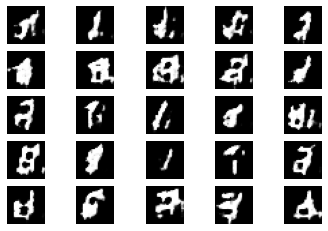

1401 [D loss: 0.910823, acc.: 50.00%] [G loss: 0.296237]
1402 [D loss: 0.907324, acc.: 50.00%] [G loss: 0.294366]
1403 [D loss: 0.912178, acc.: 50.00%] [G loss: 0.294794]
1404 [D loss: 0.909576, acc.: 50.00%] [G loss: 0.294130]
1405 [D loss: 0.912341, acc.: 50.00%] [G loss: 0.296595]
1406 [D loss: 0.904567, acc.: 50.00%] [G loss: 0.295465]
1407 [D loss: 0.907305, acc.: 50.00%] [G loss: 0.294644]
1408 [D loss: 0.910710, acc.: 50.00%] [G loss: 0.295765]
1409 [D loss: 0.905754, acc.: 50.00%] [G loss: 0.295338]
1410 [D loss: 0.903724, acc.: 50.00%] [G loss: 0.294655]
1411 [D loss: 0.910862, acc.: 50.00%] [G loss: 0.297676]
1412 [D loss: 0.908711, acc.: 50.00%] [G loss: 0.299635]
1413 [D loss: 0.903742, acc.: 50.00%] [G loss: 0.295921]
1414 [D loss: 0.907411, acc.: 50.00%] [G loss: 0.294568]
1415 [D loss: 0.909009, acc.: 50.00%] [G loss: 0.292291]
1416 [D loss: 0.911299, acc.: 50.00%] [G loss: 0.291947]
1417 [D loss: 0.909789, acc.: 50.00%] [G loss: 0.292921]
1418 [D loss: 0.902587, acc.: 5

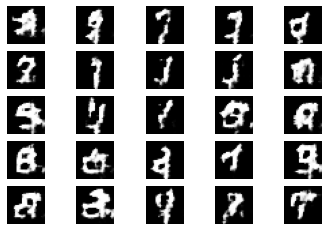

1501 [D loss: 0.909870, acc.: 50.00%] [G loss: 0.289964]
1502 [D loss: 0.909621, acc.: 50.00%] [G loss: 0.287086]
1503 [D loss: 0.911703, acc.: 50.00%] [G loss: 0.285004]
1504 [D loss: 0.910195, acc.: 50.00%] [G loss: 0.284413]
1505 [D loss: 0.914905, acc.: 50.00%] [G loss: 0.284585]
1506 [D loss: 0.912576, acc.: 50.00%] [G loss: 0.285349]
1507 [D loss: 0.908101, acc.: 50.00%] [G loss: 0.285156]
1508 [D loss: 0.914259, acc.: 50.00%] [G loss: 0.289459]
1509 [D loss: 0.902138, acc.: 50.00%] [G loss: 0.288376]
1510 [D loss: 0.907075, acc.: 50.00%] [G loss: 0.288126]
1511 [D loss: 0.910580, acc.: 50.00%] [G loss: 0.286635]
1512 [D loss: 0.903732, acc.: 50.00%] [G loss: 0.285672]
1513 [D loss: 0.912729, acc.: 50.00%] [G loss: 0.284783]
1514 [D loss: 0.912502, acc.: 50.00%] [G loss: 0.284445]
1515 [D loss: 0.909788, acc.: 50.00%] [G loss: 0.284071]
1516 [D loss: 0.913597, acc.: 50.00%] [G loss: 0.284972]
1517 [D loss: 0.908690, acc.: 50.00%] [G loss: 0.284279]
1518 [D loss: 0.913122, acc.: 5

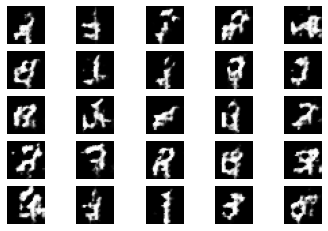

1601 [D loss: 0.913072, acc.: 50.00%] [G loss: 0.275465]
1602 [D loss: 0.914323, acc.: 50.00%] [G loss: 0.275172]
1603 [D loss: 0.917876, acc.: 50.00%] [G loss: 0.275970]
1604 [D loss: 0.914038, acc.: 50.00%] [G loss: 0.276514]
1605 [D loss: 0.912392, acc.: 50.00%] [G loss: 0.276534]
1606 [D loss: 0.914697, acc.: 50.00%] [G loss: 0.275956]
1607 [D loss: 0.912226, acc.: 50.00%] [G loss: 0.275251]
1608 [D loss: 0.913238, acc.: 50.00%] [G loss: 0.274782]
1609 [D loss: 0.917649, acc.: 50.00%] [G loss: 0.276352]
1610 [D loss: 0.913825, acc.: 50.00%] [G loss: 0.276054]
1611 [D loss: 0.910569, acc.: 50.00%] [G loss: 0.275338]
1612 [D loss: 0.917881, acc.: 50.00%] [G loss: 0.276298]
1613 [D loss: 0.915999, acc.: 50.00%] [G loss: 0.276175]
1614 [D loss: 0.911825, acc.: 50.00%] [G loss: 0.274136]
1615 [D loss: 0.918041, acc.: 50.00%] [G loss: 0.274283]
1616 [D loss: 0.915964, acc.: 50.00%] [G loss: 0.274031]
1617 [D loss: 0.915459, acc.: 50.00%] [G loss: 0.274105]
1618 [D loss: 0.918023, acc.: 5

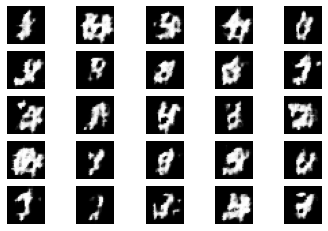

1701 [D loss: 0.941875, acc.: 50.00%] [G loss: 0.268520]
1702 [D loss: 0.927052, acc.: 50.00%] [G loss: 0.274847]
1703 [D loss: 0.900487, acc.: 50.00%] [G loss: 0.265853]
1704 [D loss: 0.933291, acc.: 50.00%] [G loss: 0.261221]
1705 [D loss: 0.943273, acc.: 50.00%] [G loss: 0.264479]
1706 [D loss: 0.928853, acc.: 50.00%] [G loss: 0.266116]
1707 [D loss: 0.927220, acc.: 50.00%] [G loss: 0.265867]
1708 [D loss: 0.928484, acc.: 50.00%] [G loss: 0.265109]
1709 [D loss: 0.931966, acc.: 50.00%] [G loss: 0.265882]
1710 [D loss: 0.927129, acc.: 50.00%] [G loss: 0.265765]
1711 [D loss: 0.932407, acc.: 50.00%] [G loss: 0.268530]
1712 [D loss: 0.923955, acc.: 50.00%] [G loss: 0.268236]
1713 [D loss: 0.927581, acc.: 50.00%] [G loss: 0.269197]
1714 [D loss: 0.923009, acc.: 50.00%] [G loss: 0.269718]
1715 [D loss: 0.921314, acc.: 50.00%] [G loss: 0.268877]
1716 [D loss: 0.927850, acc.: 50.00%] [G loss: 0.270125]
1717 [D loss: 0.920205, acc.: 50.00%] [G loss: 0.269370]
1718 [D loss: 0.924956, acc.: 5

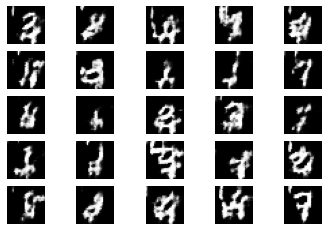

1801 [D loss: 0.908468, acc.: 50.00%] [G loss: 0.270865]
1802 [D loss: 0.905544, acc.: 50.00%] [G loss: 0.270382]
1803 [D loss: 0.907552, acc.: 50.00%] [G loss: 0.270835]
1804 [D loss: 0.904322, acc.: 50.00%] [G loss: 0.269869]
1805 [D loss: 0.909550, acc.: 50.00%] [G loss: 0.271446]
1806 [D loss: 0.902892, acc.: 50.00%] [G loss: 0.269911]
1807 [D loss: 0.909082, acc.: 50.00%] [G loss: 0.271975]
1808 [D loss: 0.903965, acc.: 50.00%] [G loss: 0.269616]
1809 [D loss: 0.910755, acc.: 50.00%] [G loss: 0.269927]
1810 [D loss: 0.907703, acc.: 50.00%] [G loss: 0.267946]
1811 [D loss: 0.910012, acc.: 50.00%] [G loss: 0.268132]
1812 [D loss: 0.909459, acc.: 50.00%] [G loss: 0.268084]
1813 [D loss: 0.912564, acc.: 50.00%] [G loss: 0.267552]
1814 [D loss: 0.912744, acc.: 50.00%] [G loss: 0.265606]
1815 [D loss: 0.914418, acc.: 50.00%] [G loss: 0.264438]
1816 [D loss: 0.916474, acc.: 50.00%] [G loss: 0.264660]
1817 [D loss: 0.913263, acc.: 50.00%] [G loss: 0.264683]
1818 [D loss: 0.916340, acc.: 5

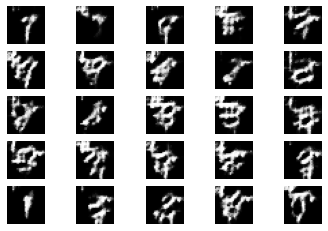

1901 [D loss: 0.927860, acc.: 50.00%] [G loss: 0.258816]
1902 [D loss: 0.927964, acc.: 50.00%] [G loss: 0.258910]
1903 [D loss: 0.925899, acc.: 50.00%] [G loss: 0.257714]
1904 [D loss: 0.933222, acc.: 50.00%] [G loss: 0.260131]
1905 [D loss: 0.922237, acc.: 50.00%] [G loss: 0.259344]
1906 [D loss: 0.933036, acc.: 50.00%] [G loss: 0.264208]
1907 [D loss: 0.916430, acc.: 50.00%] [G loss: 0.261702]
1908 [D loss: 0.928689, acc.: 50.00%] [G loss: 0.261437]
1909 [D loss: 0.922351, acc.: 50.00%] [G loss: 0.259639]
1910 [D loss: 0.925998, acc.: 50.00%] [G loss: 0.258276]
1911 [D loss: 0.929930, acc.: 50.00%] [G loss: 0.258457]
1912 [D loss: 0.925574, acc.: 50.00%] [G loss: 0.257758]
1913 [D loss: 0.932479, acc.: 50.00%] [G loss: 0.258927]
1914 [D loss: 0.925929, acc.: 50.00%] [G loss: 0.257672]
1915 [D loss: 0.932866, acc.: 50.00%] [G loss: 0.258294]
1916 [D loss: 0.925972, acc.: 50.00%] [G loss: 0.257234]
1917 [D loss: 0.931967, acc.: 50.00%] [G loss: 0.258857]
1918 [D loss: 0.924275, acc.: 5

In [56]:
train_conv(epochs = 2000, batch_size = 2048, print_interval = 100)

In [57]:
def predict_conv(vec):
  vec = np.expand_dims(vec, axis = 0)
  img = generator.predict(vec)[0, :, :, 0]
  
  return img

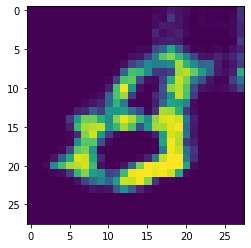

In [75]:
noise_vec = np.random.normal(0, 1, (25,))
plt.imshow(predict_conv(noise_vec))

In [59]:
vecs

array([-5.   , -4.375, -3.75 , -3.125, -2.5  , -1.875, -1.25 , -0.625,
        0.   ,  0.625,  1.25 ,  1.875,  2.5  ,  3.125,  3.75 ,  4.375,
        5.   ,  5.625,  6.25 ,  6.875,  7.5  ,  8.125,  8.75 ,  9.375,
       10.   ])